CLIP Modality Gap Analysis on STL-10
Device: cuda
CLIP Model: ViT-B/16
Batch size: 64

[1/6] Loading CLIP model...


100%|███████████████████████████████████████| 335M/335M [00:10<00:00, 34.4MiB/s]


Model loaded successfully

[2/6] Loading STL-10 dataset...


100%|██████████| 2.64G/2.64G [01:02<00:00, 42.1MB/s]


Loaded STL-10 test set: 8000 images

[3/6] Evaluating zero-shot classification with different prompts...

Evaluating Zero-Shot Classification Accuracies:
--------------------------------------------------
Plain          : 96.50%
Photo          : 98.05%
Descriptive    : 97.55%
--------------------------------------------------

[4/6] Extracting embeddings for modality gap analysis...

Extracted embeddings:
  Image embeddings shape: (100, 512)
  Text embeddings shape: (100, 512)
  Embeddings normalized: False

[5/6] Visualizing modality gap...

Applying t-SNE projection...
Figure saved to: modality_gap_original.png


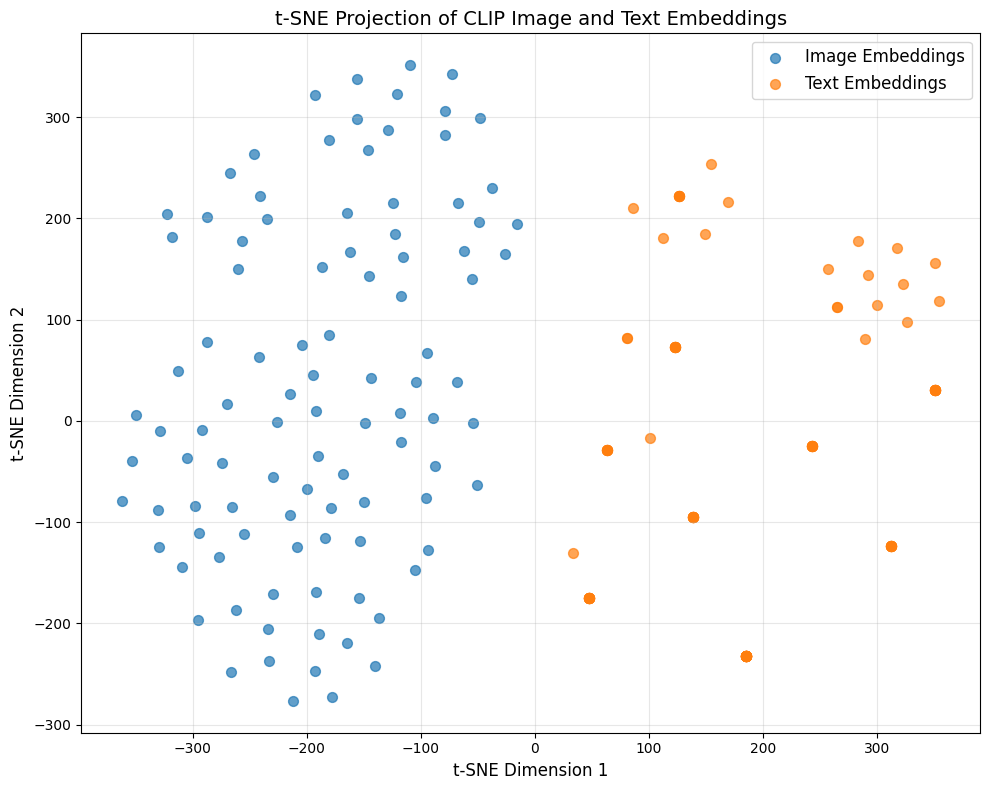


[6/6] Bridging the modality gap with Procrustes alignment...

Performing Procrustes alignment...
  Average distance before alignment: 1.2109
  Average distance after alignment: 0.4709
  Distance reduction: 61.11%

Applying t-SNE projection...
Figure saved to: modality_gap_aligned.png


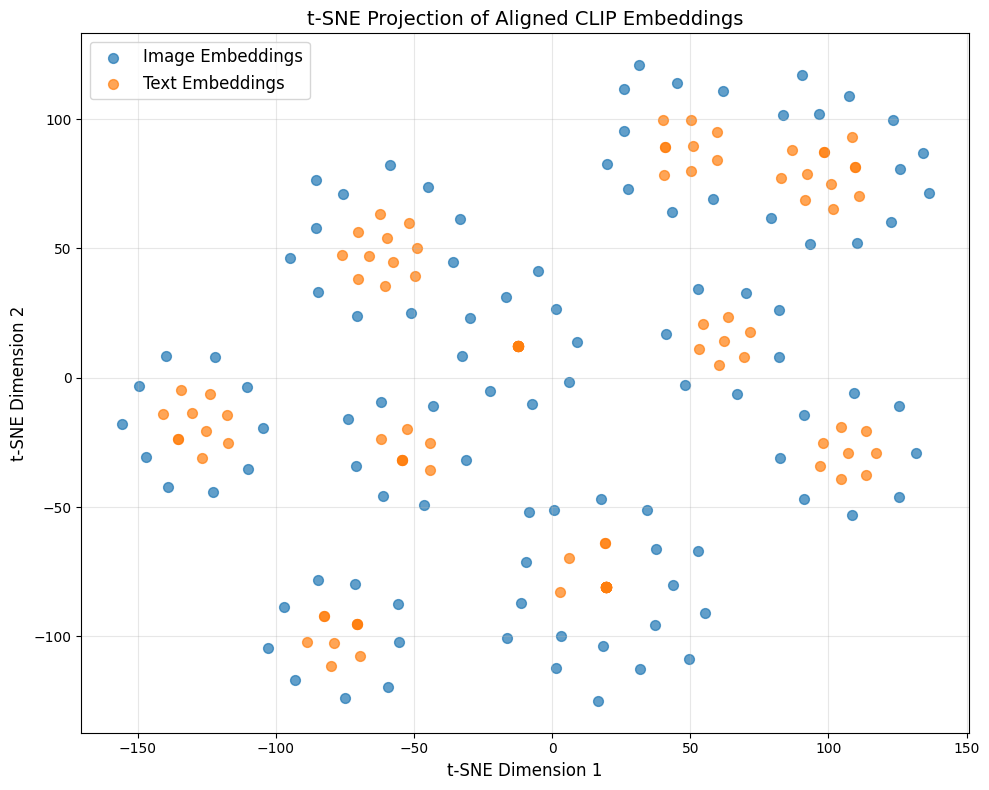


Evaluating zero-shot accuracy with aligned embeddings...

Alignment Results:
----------------------------------------------------------------------
Original Photo Prompt Accuracy: 98.05%
Aligned Photo Prompt Accuracy:  97.44%
Accuracy Change: -0.61%
Figure saved to: accuracy_comparison.png


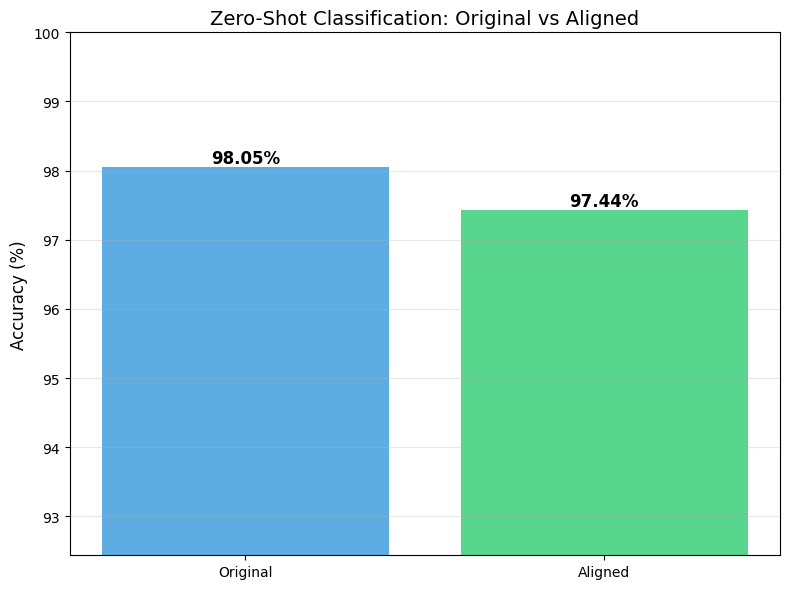


Rotation matrix saved as 'procrustes_rotation_matrix.npy'

Analysis complete!


In [2]:
!pip install openai-clip

import torch
import numpy as np
import clip
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
from scipy.linalg import orthogonal_procrustes
import matplotlib.pyplot as plt


# ============================================================================
# Configuration
# ============================================================================

class Config:
    """Configuration parameters for CLIP analysis"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    clip_model = "ViT-B/16"
    batch_size = 64
    subset_size = 100
    random_seed = 42

    # STL-10 classes
    classes = [
        'airplane', 'bird', 'car', 'cat', 'deer',
        'dog', 'horse', 'monkey', 'ship', 'truck'
    ]


# ============================================================================
# Data Loading
# ============================================================================

def load_stl10_dataset(batch_size=64):
    """Load STL-10 test dataset with appropriate preprocessing"""
    # CLIP expects ImageNet normalization
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    test_dataset = datasets.STL10(
        root='./data',
        split='test',
        download=True,
        transform=transform
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    print(f"Loaded STL-10 test set: {len(test_dataset)} images")
    return test_dataset, test_loader


# ============================================================================
# Prompt Engineering Functions
# ============================================================================

def plain_prompt(cls):
    """Plain class name prompt"""
    return cls


def photo_prompt(cls):
    """Photo-based prompt"""
    return f"a photo of a {cls}"


def descriptive_prompt(cls):
    """Descriptive prompt with context"""
    return f"a high-resolution photo of a {cls} in its natural environment"


# ============================================================================
# Zero-Shot Classification
# ============================================================================

@torch.no_grad()
def zero_shot_accuracy(model, test_loader, classes, prompt_fn, device='cpu'):
    """
    Evaluate zero-shot classification accuracy using CLIP

    Args:
        model: CLIP model
        test_loader: DataLoader for test images
        classes: List of class names
        prompt_fn: Function to generate text prompts from class names
        device: Device to run inference on

    Returns:
        accuracy: Classification accuracy as percentage
    """
    correct = 0
    total = 0

    for images, labels in test_loader:
        images = images.to(device)

        # Encode images
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # Generate and encode text prompts
        texts = [prompt_fn(cls) for cls in classes]
        text_tokens = clip.tokenize(texts).to(device)
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Compute similarity and predict
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        pred = similarity.argmax(dim=1)

        correct += (pred == labels.to(device)).sum().item()
        total += labels.size(0)

    return correct / total * 100


def evaluate_prompt_strategies(model, test_loader, classes, device='cpu'):
    """Evaluate different prompt engineering strategies"""
    prompt_strategies = {
        'Plain': plain_prompt,
        'Photo': photo_prompt,
        'Descriptive': descriptive_prompt
    }

    results = {}
    print("\nEvaluating Zero-Shot Classification Accuracies:")
    print("-" * 50)

    for name, prompt_fn in prompt_strategies.items():
        acc = zero_shot_accuracy(model, test_loader, classes, prompt_fn, device)
        results[name] = acc
        print(f"{name:15s}: {acc:.2f}%")

    print("-" * 50)
    return results


# ============================================================================
# Embedding Extraction
# ============================================================================

@torch.no_grad()
def extract_embeddings(model, dataset, classes, n_samples=100, device='cpu'):
    """
    Extract image and corresponding text embeddings

    Args:
        model: CLIP model
        dataset: Dataset to sample from
        classes: List of class names
        n_samples: Number of samples to extract
        device: Device to run inference on

    Returns:
        image_emb: Normalized image embeddings
        text_emb: Normalized text embeddings
        labels: Corresponding labels
    """
    # Create a subset loader
    subset_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=n_samples,
        shuffle=True
    )

    images, labels = next(iter(subset_loader))
    images = images.to(device)

    # Extract image embeddings
    image_features = model.encode_image(images)
    image_emb = image_features.detach().cpu().numpy()
    image_emb /= np.linalg.norm(image_emb, axis=1, keepdims=True)

    # Extract corresponding text embeddings
    text_prompts = [f"a photo of a {classes[label]}" for label in labels]
    text_tokens = clip.tokenize(text_prompts).to(device)
    text_features = model.encode_text(text_tokens)
    text_emb = text_features.detach().cpu().numpy()
    text_emb /= np.linalg.norm(text_emb, axis=1, keepdims=True)

    print(f"\nExtracted embeddings:")
    print(f"  Image embeddings shape: {image_emb.shape}")
    print(f"  Text embeddings shape: {text_emb.shape}")
    print(f"  Embeddings normalized: {np.allclose(np.linalg.norm(image_emb, axis=1), 1.0, atol=1e-5)}")

    return image_emb, text_emb, labels.numpy()


# ============================================================================
# Visualization Functions
# ============================================================================

def visualize_modality_gap(image_emb, text_emb, title="CLIP Embeddings",
                          save_path=None):
    """
    Visualize the modality gap using t-SNE projection

    Args:
        image_emb: Image embeddings
        text_emb: Text embeddings
        title: Plot title
        save_path: Path to save the figure
    """
    # Combine embeddings
    all_emb = np.concatenate([image_emb, text_emb], axis=0)

    # Apply t-SNE
    print(f"\nApplying t-SNE projection...")
    tsne = TSNE(n_components=2, random_state=42)
    proj = tsne.fit_transform(all_emb)

    # Split back
    image_proj = proj[:len(image_emb)]
    text_proj = proj[len(image_emb):]

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(image_proj[:, 0], image_proj[:, 1],
               label='Image Embeddings', alpha=0.7, s=50)
    plt.scatter(text_proj[:, 0], text_proj[:, 1],
               label='Text Embeddings', alpha=0.7, s=50)
    plt.legend(fontsize=12)
    plt.title(title, fontsize=14)
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")

    plt.show()


def plot_accuracy_comparison(original_acc, aligned_acc, save_path=None):
    """
    Plot comparison of original vs aligned accuracies
    """
    categories = ['Original', 'Aligned']
    accuracies = [original_acc, aligned_acc]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(categories, accuracies, color=['#3498db', '#2ecc71'], alpha=0.8)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Zero-Shot Classification: Original vs Aligned', fontsize=14)
    plt.ylim([min(accuracies) - 5, 100])

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.2f}%',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")

    plt.show()


# ============================================================================
# Procrustes Alignment
# ============================================================================

def align_embeddings(source_emb, target_emb):
    """
    Align source embeddings to target embeddings using Procrustes analysis

    Args:
        source_emb: Source embeddings to align (e.g., image embeddings)
        target_emb: Target embeddings (e.g., text embeddings)

    Returns:
        R: Rotation matrix
        aligned_emb: Aligned source embeddings
    """
    print("\nPerforming Procrustes alignment...")

    # Find optimal rotation matrix
    R, scale = orthogonal_procrustes(source_emb, target_emb)

    # Apply rotation and re-normalize
    aligned_emb = source_emb @ R
    aligned_emb /= np.linalg.norm(aligned_emb, axis=1, keepdims=True)

    # Compute alignment metrics
    before_dist = np.linalg.norm(source_emb - target_emb, axis=1).mean()
    after_dist = np.linalg.norm(aligned_emb - target_emb, axis=1).mean()

    print(f"  Average distance before alignment: {before_dist:.4f}")
    print(f"  Average distance after alignment: {after_dist:.4f}")
    print(f"  Distance reduction: {(1 - after_dist/before_dist)*100:.2f}%")

    return R, aligned_emb


@torch.no_grad()
def zero_shot_accuracy_aligned(model, test_loader, classes, prompt_fn,
                               rotation_matrix, device='cpu'):
    """
    Evaluate zero-shot accuracy using aligned embeddings

    Args:
        model: CLIP model
        test_loader: DataLoader for test images
        classes: List of class names
        prompt_fn: Function to generate text prompts
        rotation_matrix: Rotation matrix from Procrustes alignment
        device: Device to run inference on

    Returns:
        accuracy: Classification accuracy as percentage
    """
    # Extract all image embeddings
    all_image_emb = []
    all_labels = []

    for images, labels_batch in test_loader:
        images = images.to(device)
        emb = model.encode_image(images)
        emb = emb.detach().cpu().numpy()
        emb /= np.linalg.norm(emb, axis=1, keepdims=True)
        all_image_emb.append(emb)
        all_labels.append(labels_batch.numpy())

    all_image_emb = np.concatenate(all_image_emb, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Apply alignment
    aligned_image_emb = all_image_emb @ rotation_matrix
    aligned_image_emb /= np.linalg.norm(aligned_image_emb, axis=1, keepdims=True)
    aligned_image_emb = torch.from_numpy(aligned_image_emb).to(device).float()

    # Extract text features
    texts = [prompt_fn(cls) for cls in classes]
    text_tokens = clip.tokenize(texts).to(device)
    text_features = model.encode_text(text_tokens)
    text_features = text_features.float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.detach()

    # Compute similarity and accuracy
    similarity = (100.0 * aligned_image_emb @ text_features.T).softmax(dim=-1)
    pred = similarity.argmax(dim=1).cpu().numpy()
    acc = (pred == all_labels).mean() * 100

    return acc


# ============================================================================
# Main Execution
# ============================================================================

def main():
    """Main analysis pipeline"""
    config = Config()

    print("=" * 70)
    print("CLIP Modality Gap Analysis on STL-10")
    print("=" * 70)
    print(f"Device: {config.device}")
    print(f"CLIP Model: {config.clip_model}")
    print(f"Batch size: {config.batch_size}")
    print("=" * 70)

    # Load CLIP model
    print("\n[1/6] Loading CLIP model...")
    model, preprocess = clip.load(config.clip_model, device=config.device)
    print(f"Model loaded successfully")

    # Load dataset
    print("\n[2/6] Loading STL-10 dataset...")
    test_dataset, test_loader = load_stl10_dataset(config.batch_size)

    # Evaluate zero-shot classification
    print("\n[3/6] Evaluating zero-shot classification with different prompts...")
    prompt_results = evaluate_prompt_strategies(
        model, test_loader, config.classes, config.device
    )

    # Extract embeddings for visualization
    print("\n[4/6] Extracting embeddings for modality gap analysis...")
    image_emb, text_emb, labels = extract_embeddings(
        model, test_dataset, config.classes,
        n_samples=config.subset_size, device=config.device
    )

    # Visualize original modality gap
    print("\n[5/6] Visualizing modality gap...")
    visualize_modality_gap(
        image_emb, text_emb,
        title="t-SNE Projection of CLIP Image and Text Embeddings",
        save_path="modality_gap_original.png"
    )

    # Perform Procrustes alignment
    print("\n[6/6] Bridging the modality gap with Procrustes alignment...")
    rotation_matrix, aligned_image_emb = align_embeddings(image_emb, text_emb)

    # Visualize aligned embeddings
    visualize_modality_gap(
        aligned_image_emb, text_emb,
        title="t-SNE Projection of Aligned CLIP Embeddings",
        save_path="modality_gap_aligned.png"
    )

    # Evaluate aligned accuracy
    print("\nEvaluating zero-shot accuracy with aligned embeddings...")
    original_acc = prompt_results['Photo']
    aligned_acc = zero_shot_accuracy_aligned(
        model, test_loader, config.classes, photo_prompt,
        rotation_matrix, config.device
    )

    print("\n" + "=" * 70)
    print("Alignment Results:")
    print("-" * 70)
    print(f"Original Photo Prompt Accuracy: {original_acc:.2f}%")
    print(f"Aligned Photo Prompt Accuracy:  {aligned_acc:.2f}%")
    print(f"Accuracy Change: {aligned_acc - original_acc:+.2f}%")
    print("=" * 70)

    # Plot comparison
    plot_accuracy_comparison(
        original_acc, aligned_acc,
        save_path="accuracy_comparison.png"
    )

    # Save rotation matrix
    np.save('procrustes_rotation_matrix.npy', rotation_matrix)
    print("\nRotation matrix saved as 'procrustes_rotation_matrix.npy'")

    print("\n" + "=" * 70)
    print("Analysis complete!")
    print("=" * 70)

    return {
        'prompt_results': prompt_results,
        'original_accuracy': original_acc,
        'aligned_accuracy': aligned_acc,
        'rotation_matrix': rotation_matrix
    }


if __name__ == "__main__":
    results = main()